# Glassdoor Sentiment Analysis

## Main Goal

The aspect-based sentiment analysis (or joint sentiment analysis and topic spotting) is a really interesting avenue that is supported by the Glassdoor data's rating structure. We will utilize feature-specific approaches to predict ratings on workplace culture, benefits, and more.

## Preprocessing Data

In [1]:
import sys
sys.path.insert(0, 'cs224u_files')

from collections import Counter
from nltk.tree import Tree
from sklearn.feature_extraction import DictVectorizer
import numpy as np
import os
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
from sklearn.model_selection import StratifiedKFold
import utils
from nltk.tokenize import sent_tokenize, word_tokenize
import helpers
import csv
from nltk.corpus import opinion_lexicon
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [2]:
GLASSDOOR_HOME = 'glassdoor-data'

These splits are all stratified. We create a separate splits for the following:

1. rating_balance
2. rating_culture
3. rating_career
4. rating_comp
5. rating_mgmt

In [3]:
balance_split = helpers.train_dev_test_split(GLASSDOOR_HOME, output_var='rating_balance', random_state=1)
culture_split = helpers.train_dev_test_split(GLASSDOOR_HOME, output_var='rating_culture', random_state=1)
career_split = helpers.train_dev_test_split(GLASSDOOR_HOME, output_var='rating_career', random_state=1)
comp_split = helpers.train_dev_test_split(GLASSDOOR_HOME, output_var='rating_comp', random_state=1)
mgmt_split = helpers.train_dev_test_split(GLASSDOOR_HOME, output_var='rating_mgmt', random_state=1)

Created splits for rating_balance
Created splits for rating_culture
Created splits for rating_career
Created splits for rating_comp
Created splits for rating_mgmt


In [4]:
feature_splits = (
    ('Work/Life Balance', balance_split), 
    ('Culture & Values', culture_split), 
    ('Career Opportunities', career_split), 
    ('Compensation and Benefits', comp_split),
    ('Senior Management', mgmt_split),
)

We can show that these splits are stratified by checking the distribution. We'll do so for overall_split. As we can see, the overall ratings have a heavy left skew, as most ratings are positive.

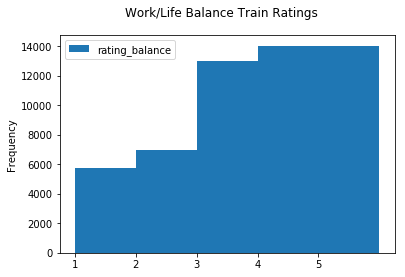

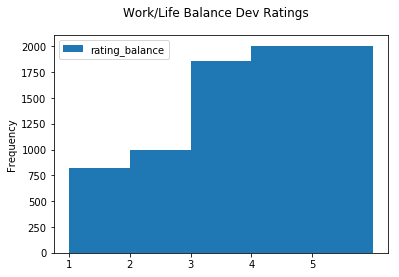

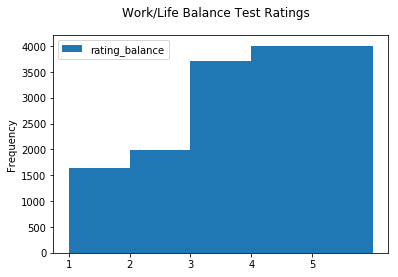

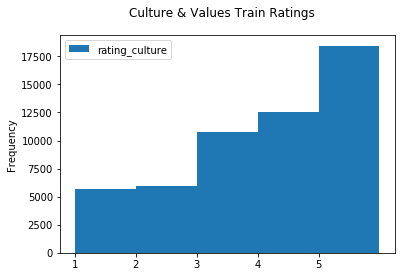

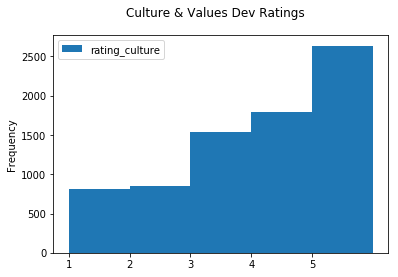

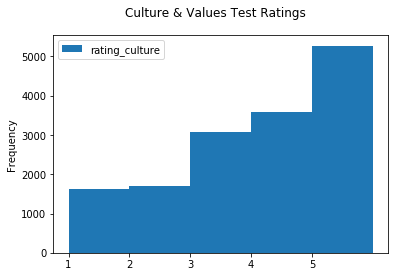

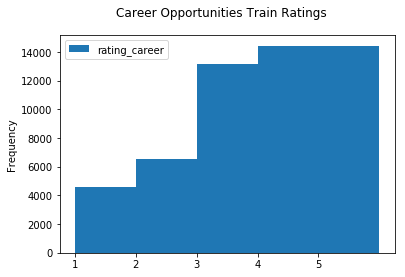

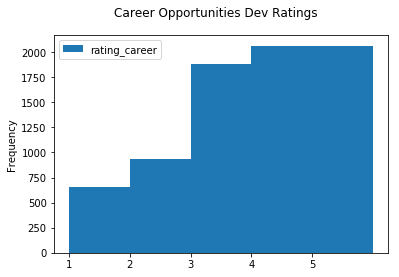

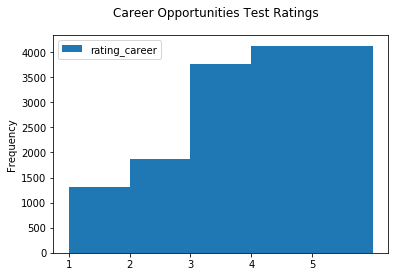

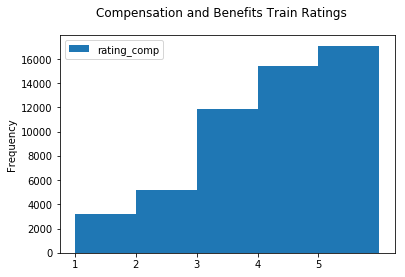

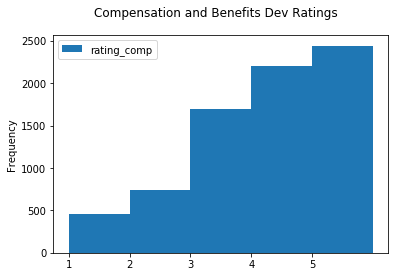

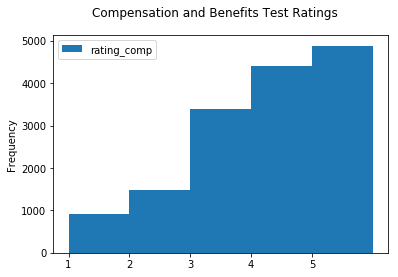

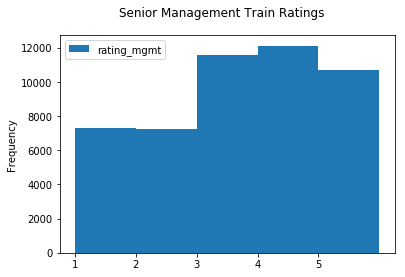

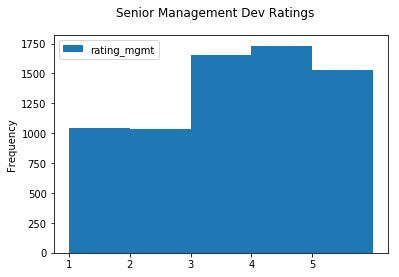

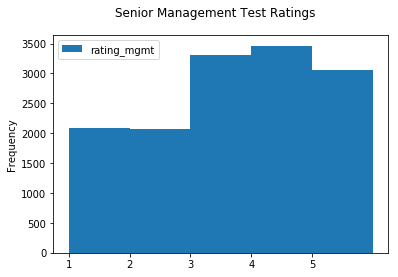

In [6]:
def plot_hist(y, title):
    ax = y.plot.hist(subplots=True, sharex=True, sharey=True, bins=[1, 2, 3, 4, 5, 6], title=title, xticks=[1, 2, 3, 4, 5])

for feature_name, split in feature_splits:
    X_train, X_dev, X_test, y_train, y_dev, y_test = split
    
    plot_hist(y_train, '{} Train Ratings'.format(feature_name))
    plot_hist(y_dev, '{} Dev Ratings'.format(feature_name))
    plot_hist(y_test, '{} Test Ratings'.format(feature_name))

## Functions for Experimentation and Metrics

In [5]:
def experiment(phi, classifier, assess='dev', verbose=True, vectorize=True, use_sparse_vectorizer=False):
    all_results = []
    
    for feature_name, split in feature_splits:
        X_train = split[0]
        y_train = split[3]
        
        if assess == 'dev':
            X_assess = split[1]
            y_assess = split[4]
        else: # use test
            X_assess = split[2]
            y_assess = split[5]
            
        if verbose:
            print (feature_name)
        
        experimental_results = helpers.experiment(
            feature_name,
            phi,
            X_train,
            y_train,
            X_assess,
            y_assess,
            classifier,
            verbose=verbose,
            vectorize=vectorize,
            use_sparse_vectorizer=use_sparse_vectorizer)
        
        all_results.append((feature_name, experimental_results))

    return all_results

In [6]:
def get_ci(vals):
    if len(set(vals)) == 1:
        return (vals[0], vals[0])
    loc = np.mean(vals)
    scale = np.std(vals) / np.sqrt(len(vals))
    return stats.t.interval(0.95, len(vals)-1, loc=loc, scale=scale)

def plot_score(scores, score_func="Macro F1"):
    scores = pd.Series(scores)
    
    ax = scores.plot()
    ax.set_xlabel("Epochs")
    _ = ax.set_ylabel(score_func)

def illustrative_confusion_matrix(y, predictions, classes, class_func=lambda x: x,):
    true_vals = [class_func(curr_y) for curr_y in y.values]
    conf_matrix = confusion_matrix(true_vals, predictions, labels=classes)
    
    ex = pd.DataFrame(
        conf_matrix,        
        columns=classes,
        index=classes)
    ex.index.name = "observed"
    
    return ex

def accuracy(cm):
    return cm.values.diagonal().sum() / cm.values.sum()

def precision(cm):
    return cm.values.diagonal() / cm.sum(axis=0)

def recall(cm):
    return cm.values.diagonal() / cm.sum(axis=1)

def f_score(cm, beta):
    p = precision(cm)
    r = recall(cm)
    return (beta**2 + 1) * ((p * r) / ((beta**2 * p) + r))

def f1_score(cm):
    return f_score(cm, beta=1.0)

def macro_f_score(cm, beta):
    return f_score(cm, beta).mean(skipna=False)

In [7]:
import pickle
def write_pkl(title, contents):
    output = open('{}.pkl'.format(title), 'wb')
    pickle.dump(contents, output)
    output.close()

## Random Classifier

In [8]:
for feature_name, split in feature_splits:
    print (feature_name)
    
    # use test, no training
    y_assess = split[5]
    y_preds = np.random.randint(1, 6, y_assess.shape)
    print (classification_report(y_assess, y_preds))

Work/Life Balance
              precision    recall  f1-score   support

           1       0.11      0.20      0.14      1636
           2       0.14      0.21      0.17      1994
           3       0.24      0.20      0.22      3714
           4       0.26      0.20      0.22      4009
           5       0.26      0.20      0.22      4001

   micro avg       0.20      0.20      0.20     15354
   macro avg       0.20      0.20      0.19     15354
weighted avg       0.22      0.20      0.21     15354

Culture & Values
              precision    recall  f1-score   support

           1       0.10      0.19      0.13      1631
           2       0.11      0.19      0.14      1705
           3       0.20      0.20      0.20      3074
           4       0.23      0.20      0.22      3584
           5       0.34      0.20      0.25      5271

   micro avg       0.20      0.20      0.20     15265
   macro avg       0.20      0.20      0.19     15265
weighted avg       0.24      0.20      0.2

## A softmax baseline

We first utilize a baseline approach that leverages a bag of words featurizer and logistic regression.

In [9]:
# Bag of words
def unigrams_phi(example):
    counter = Counter()
    
    parts = example[['review_title', 'pros', 'cons', 'advice_to_mgmt']]
    for part in parts:
        counter.update([w.lower() for w in word_tokenize(part)])
        
    return counter

In [8]:
def fit_softmax_classifier(X, y):        
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='ovr',
        class_weight='balanced',
        max_iter=200)
    mod.fit(X, y)
    return mod

In [11]:
softmax_results = experiment(
    unigrams_phi,
    fit_softmax_classifier,
    use_sparse_vectorizer=True)

Work/Life Balance


/home/chungchang/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           1      0.368     0.438     0.400       818
           2      0.220     0.226     0.223       997
           3      0.315     0.265     0.288      1857
           4      0.313     0.285     0.298      2005
           5      0.434     0.497     0.463      2000

   micro avg      0.344     0.344     0.344      7677
   macro avg      0.330     0.342     0.334      7677
weighted avg      0.339     0.344     0.340      7677

Culture & Values
              precision    recall  f1-score   support

           1      0.420     0.464     0.441       816
           2      0.219     0.222     0.220       852
           3      0.292     0.277     0.284      1537
           4      0.332     0.293     0.311      1792
           5      0.602     0.646     0.623      2636

   micro avg      0.422     0.422     0.422      7633
   macro avg      0.373     0.380     0.376      7633
weighted avg      0.414     0.422     0.417      7633

Caree

In [12]:
write_pkl('softmax_experiment_baseline', softmax_results)

## Utilizing Review Structure

In [13]:
# Bag of words
def structured_unigrams_phi(example):
    counter = Counter()
    
    labels = ['review_title', 'pros', 'cons', 'advice_to_mgmt']
    parts = example[labels]
    for label, part in zip(labels, parts):
        counter.update(['{}/{}'.format(label, w.lower()) for w in word_tokenize(part)])
    
    return counter

In [14]:
structured_softmax_results = experiment(
    structured_unigrams_phi,
    fit_softmax_classifier,
    use_sparse_vectorizer=True)

Work/Life Balance
              precision    recall  f1-score   support

           1      0.405     0.433     0.418       818
           2      0.248     0.255     0.251       997
           3      0.311     0.295     0.303      1857
           4      0.336     0.305     0.319      2005
           5      0.485     0.533     0.508      2000

   micro avg      0.369     0.369     0.369      7677
   macro avg      0.357     0.364     0.360      7677
weighted avg      0.365     0.369     0.366      7677

Culture & Values
              precision    recall  f1-score   support

           1      0.439     0.472     0.455       816
           2      0.223     0.218     0.221       852
           3      0.301     0.295     0.298      1537
           4      0.331     0.297     0.313      1792
           5      0.613     0.653     0.632      2636

   micro avg      0.429     0.429     0.429      7633
   macro avg      0.381     0.387     0.384      7633
weighted avg      0.422     0.429     0.42

In [15]:
write_pkl('structured_softmax_experiment_baseline', structured_softmax_results)

## Utilizing Vector Representations

We will model each section as the sum of its 300-dimensional GloVe representations, resulting in a 1200-dimensional vector for each review. A neural network might do better here, since there might be complex relationships between the input feature dimensions that a linear classifier can't learn. 

In [16]:
DATA_HOME = 'cs224u_files/data'
GLOVE_HOME = os.path.join(DATA_HOME, 'glove.6B')

glove_lookup = utils.glove2dict(
    os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))

In [17]:
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

def vsm_leaves_phi(example, lookup, np_func=np.sum):
    labels = ['review_title', 'pros', 'cons', 'advice_to_mgmt']
    parts = example[labels]
    
    dim = len(next(iter(lookup.values())))
    feats = np.zeros(dim * 4)
    
    for i, label in enumerate(labels):
        allvecs = np.array([lookup[w.lower()] for w in word_tokenize(parts[i]) if w.lower() in lookup])    
        if len(allvecs) != 0:
            feats[i * dim : (i + 1) * dim] = np_func(allvecs, axis=0)  
        
    return feats

def glove_leaves_phi(example, np_func=np.sum):
    return vsm_leaves_phi(example, glove_lookup, np_func=np_func)

def fit_torch_shallow_neural_classifier(X, y):
    mod = TorchShallowNeuralClassifier(
        hidden_dim=100, 
        hidden_activation=nn.ReLU()
    )
    mod.fit(X, y)
    return mod

In [18]:
glove_neural_results = experiment(
    glove_leaves_phi,
    fit_torch_shallow_neural_classifier,
    vectorize=False)

Work/Life Balance


Finished epoch 100 of 100; error is 67.86079680919647

              precision    recall  f1-score   support

           1      0.400     0.516     0.451       818
           2      0.246     0.014     0.027       997
           3      0.311     0.421     0.358      1857
           4      0.341     0.263     0.297      2005
           5      0.463     0.581     0.515      2000

   micro avg      0.379     0.379     0.379      7677
   macro avg      0.352     0.359     0.329      7677
weighted avg      0.360     0.379     0.350      7677

Culture & Values


Finished epoch 100 of 100; error is 59.13602375984192

              precision    recall  f1-score   support

           1      0.440     0.618     0.514       816
           2      0.278     0.018     0.033       852
           3      0.307     0.491     0.378      1537
           4      0.340     0.126     0.184      1792
           5      0.578     0.726     0.644      2636

   micro avg      0.447     0.447     0.447      7633
   macro avg      0.389     0.396     0.351      7633
weighted avg      0.419     0.447     0.400      7633

Career Opportunities


Finished epoch 100 of 100; error is 60.344422817230225

              precision    recall  f1-score   support

           1      0.467     0.320     0.379       657
           2      0.172     0.023     0.041       939
           3      0.333     0.514     0.404      1879
           4      0.359     0.355     0.357      2064
           5      0.524     0.529     0.526      2064

   micro avg      0.397     0.397     0.397      7603
   macro avg      0.371     0.348     0.342      7603
weighted avg      0.383     0.397     0.377      7603

Compensation and Benefits


Finished epoch 100 of 100; error is 59.22069323062897

              precision    recall  f1-score   support

           1      0.360     0.270     0.309       455
           2      0.351     0.044     0.079       742
           3      0.321     0.437     0.370      1697
           4      0.380     0.285     0.326      2205
           5      0.522     0.671     0.587      2441

   micro avg      0.420     0.420     0.420      7540
   macro avg      0.387     0.342     0.334      7540
weighted avg      0.409     0.420     0.395      7540

Senior Management


Finished epoch 100 of 100; error is 55.211230754852295

              precision    recall  f1-score   support

           1      0.557     0.545     0.551      1043
           2      0.282     0.083     0.128      1039
           3      0.331     0.436     0.376      1653
           4      0.369     0.402     0.385      1732
           5      0.511     0.536     0.523      1531

   micro avg      0.413     0.413     0.413      6998
   macro avg      0.410     0.400     0.393      6998
weighted avg      0.406     0.413     0.400      6998



In [19]:
write_pkl('glove_shallow_nn_baseline', glove_neural_results)

## Do Bigrams Do Better?

In [20]:
# Helper functions
def get_ngrams(words, n, transform=lambda x:x):
    ngrams = []

    words.insert(0, '<s>')
    words.append('</s>')
    
    if len(words) < n:
        return ngrams
    
    for i in range(n - 1, len(words)):
        ngrams.append(transform(' '.join(words[i - n + 1: i + 1])))
        
    return ngrams

In [21]:
# Bag of words
def structured_bigrams_phi(example):
    counter = Counter()
    
    labels = ['review_title', 'pros', 'cons', 'advice_to_mgmt']
    parts = example[labels]
    for label, part in zip(labels, parts):
        counter.update(get_ngrams(word_tokenize(part), 2, transform=lambda x: '{}/{}'.format(label, x).lower()))
    
    return counter

In [22]:
structured_bigrams_softmax_results = experiment(
    structured_bigrams_phi,
    fit_softmax_classifier,
    use_sparse_vectorizer=True)

Work/Life Balance
              precision    recall  f1-score   support

           1      0.489     0.479     0.484       816
           2      0.253     0.188     0.215       852
           3      0.296     0.291     0.293      1537
           4      0.321     0.305     0.313      1792
           5      0.594     0.673     0.631      2636

   micro avg      0.435     0.435     0.435      7633
   macro avg      0.391     0.387     0.387      7633
weighted avg      0.421     0.435     0.426      7633

Career Opportunities
              precision    recall  f1-score   support

           1      0.419     0.364     0.390       657
           2      0.259     0.202     0.227       939
           3      0.337     0.353     0.345      1879
           4      0.352     0.354     0.353      2064
           5      0.511     0.559     0.534      2064

   micro avg      0.391     0.391     0.391      7603
   macro avg      0.376     0.366     0.370      7603
weighted avg      0.386     0.391     

In [23]:
write_pkl('structured_bigrams_softmax_experiment_baseline', structured_bigrams_softmax_results)

## Optimal Model

In [ ]:
from nltk.corpus import wordnet as wn

def get_synonyms(words):
    synonyms = words
    
    for word in words:
        try:
            synsets = wn.synsets(word)
            for synset in synsets:
                synonyms.extend(synset.lemma_names())
        except Exception as e:
            pass

    return list(set(synonyms))

KEYWORDS = {
    'Work/Life Balance':         get_synonyms(['work', 'life', 'balance', 'company', 'companies,' 'time', 'job', 'hours', \
                                              'flexible', 'PTO', 'vacation', 'schedule', 'day', 'night', 'health', \
                                               'pace', 'energy', 'flexibility', 'family', 'pressure', 'stress', \
                                               'holidays']), 
    'Culture & Values':          get_synonyms(['culture', 'value', 'people', 'coworker', 'co-worker', 'employee', 'moral', \
                                               'ethics', 'principle', 'environment', 'team', 'support', \
                                               'development', 'competitive', 'politics', 'respect', 'corporate', \
                                               'friendly', 'atmosphere', 'impact', 'colleague']), 
    'Career Opportunities':      get_synonyms(['career', 'growth', 'grow', 'opportunities', 'opportunity', 'promotion', \
                                               'mobility', 'learn', 'position', 'goal']), 
    'Compensation and Benefits': get_synonyms(['salary', 'pay', 'paid', 'money', 'cash', 'check', 'wage', \
                                               'compensation', 'income', 'benefit', 'free', 'food', 'breakfast', \
                                               'lunch', 'dinner', 'bonus', 'PTO', 'vacation', '401k', 'health', 'care', \
                                               'insurance', 'perks', 'commission', 'stock', 'raise', 'amount', 'location', \
                                               'happy hour']),
    'Senior Management':         get_synonyms(['senior', 'management', 'manager', 'boss', 'superior', 'leader', \
                                               'beauracracy', 'chief', 'high', 'old', 'structure', 'feedback', \
                                               'executive', 'supervisor']),
}

In [ ]:
def contains_keyword(sentence, feature_name):
    keywords = KEYWORDS[feature_name]
    for keyword in keywords:
        if keyword in sentence:
            return True
    return False
    
def structured_filtered_unigrams_phi(example, feature_name):
    counter = Counter()
    
    labels = ['review_title', 'pros', 'cons', 'advice_to_mgmt']
    parts = example[labels]
    
    for label, part in zip(labels, parts):
        sentences = sent_tokenize(part)
        for sentence in sentences:
            if contains_keyword(sentence, feature_name):
                counter.update(['{}/{}'.format(label, w.lower()) for w in word_tokenize(sentence)])
    
    return counter

In [ ]:
structured_filtered_softmax_results = experiment(
    structured_filtered_unigrams_phi,
    fit_softmax_classifier,
    use_sparse_vectorizer=True)

## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `helpers.experiment`. These have the following structure:

```
'model': trained model
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_dataset': same structure as the value of 'train_dataset'
'predictions': predictions on the assessment data
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the assessment data
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [96]:
def format_example(ex):
    review_title, props, cons, advice = ex[['review_title', 'pros', 'cons', 'advice_to_mgmt']]
    return 'Title: {}\nPros:\n {}\nCons:\n{}\nAdvice to Mgmt:\n{}'.format(review_title, props, cons, advice)

def find_errors(experiment):
    """Find mistaken predictions.
    
    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.
        
    Returns
    -------
    pd.DataFrame
    
    """
    raw_examples = experiment['assess_dataset']['raw_examples']
    raw_examples = [format_example(ex) for ex in raw_examples]
    df = pd.DataFrame({
        'raw_examples': raw_examples,
        'predicted': experiment['predictions'],
        'gold': experiment['assess_dataset']['y']})
    df['correct'] = df['predicted'] == df['gold']
    return df

In [97]:
softmax_analysis = find_errors(softmax_experiment)

In [28]:
rnn_analysis = find_errors(rnn_experiment)

Here we merge the sotmax and RNN experiments into a single DataFrame:

In [29]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

The following code collects a specific subset of examples; small modifications to its structure will give you different interesting subsets:

In [30]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])    
    &
    (analysis['gold'] == 'positive')
]

In [31]:
error_group.shape[0]

71

In [32]:
for ex in error_group['raw_examples'].sample(5):
    print("="*70)
    print(ex)

It 's a beautiful madness .
One of the smartest takes on singles culture I 've seen in a long time .
But it still jingles in the pocket .
For the first time in years , De Niro digs deep emotionally , perhaps because he 's been stirred by the powerful work of his co-stars .
With Rabbit-Proof Fence , Noyce has tailored an epic tale into a lean , economical movie .


In [13]:
name, softmax_experiment = softmax_results[0]
illustrative_confusion_matrix(culture_split[4], softmax_experiment['predictions'], [1, 2, 3, 4, 5])

,1,2,3,4,5
observed,,,,,
1,319,119,181,93,104
2,151,124,251,174,152
3,122,143,423,411,438
4,58,95,323,519,797
5,28,57,239,430,1882


### Your original system [4 points]

Your task is to develop an original model for the SST ternary problem. There are many options. If you spend more than a few hours on this homework problem, you should consider letting it grow into your final project! Here are some relatively manageable ideas that you might try:

1. We didn't systematically evaluate the `bidirectional` option to the `TorchRNNClassifier`. Similarly, that model could be tweaked to allow multiple LSTM layers (at present there is only one), and you could try adding layers to the classifier portion of the model as well.

1. We've already glimpsed the power of rich initial word representations, and later in the course we'll see that smart initialization usually leads to a performance gain in NLP, so you could perhaps achieve a winning entry with a simple model that starts in a great place.

1. The [practical introduction to contextual word representations](contextualreps.ipynb) (to be discussed later in the quarter) covers pretrained representations and interfaces that are likely to boost the performance of any system.

1. The `TreeNN` and `TorchTreeNN` don't perform all that well, and this could be for the same reason that RNNs don't peform well: the gradient signal doesn't propagate reliably down inside very deep trees. [Tai et al. 2015](https://aclanthology.info/papers/P15-1150/p15-1150) sought to address this with TreeLSTMs, which are fairly easy to implement in PyTorch.

1. In the [distributed representations as features](#Distributed-representations-as-features) section, we just summed  all of the leaf-node GloVe vectors to obtain a fixed-dimensional representation for all sentences. This ignores all of the tree structure. See if you can do better by paying attention to the binary tree structure: write a function `glove_subtree_phi` that obtains a vector representation for each subtree by combining the vectors of its daughters, with the leaf nodes again given by GloVe (any dimension you like) and the full representation of the sentence given by the final vector obtained by this recursive process. You can decide on how you combine the vectors. 

1. If you have a lot of computing resources, then you can fire off a large hyperparameter search over many parameter values. All the model classes for this course are compatible with the `scikit-learn` and [scikit-optimize](https://scikit-optimize.github.io) methods, because they define the required functions for getting and setting parameters.

We want to emphasize that this needs to be an __original__ system. It doesn't suffice to download code from the Web, retrain, and submit. You can build on others' code, but you have to do something new and meaningful with it.

__Please include a brief prose description of your system along with your code, to help the teaching team understand the structure of your system.__

### Model Description

We tried various approaches for our own system, attempting to utilize the TorchShallowNeuralClassifier, RandomForestClassifier, and our custom 4-layer neural network (TorchCustomNeuralClassifier) before settling on using a TorchRNNClassifierModel. We extended the class to be able to handle multiple layers and utilize dropout.

Our final system was a RNN that:

1. Utilized contextual information using BERT uncased_L-12_H-768_A-12 model, with words as features.
2. Explored the hyperparameter space. Used various values for hidden_dim, dropout, and bidirectionality.
3. Tried using both 1 and 2 LSTM layers. However, we did not edit the classifer portion of the RNN.

In [52]:
from bert_serving.client import BertClient 

def bert_sentence_phi(tree):
    s = " ".join(tree.leaves())
    return bert_lookup[s]

def bert_rnn_sentence_phi(tree):
    s = " ".join(tree.leaves())
    return bert_word_lookup[s]

def bert_reduce_mean(X):
    return X.mean(axis=1)  

bc = BertClient(check_length=False)

# Read train and dev
sst_train_reader = sst.train_reader(
    SST_HOME, class_func=sst.ternary_class_func)
sst_train = [(" ".join(t.leaves()), label) for t, label in sst_train_reader]

sst_dev_reader = sst.dev_reader(
    SST_HOME, class_func=sst.ternary_class_func)
sst_dev = [(" ".join(t.leaves()), label) for t, label in sst_dev_reader]

# Zip
X_str_train, y_train = zip(*sst_train)
X_str_dev, y_dev = zip(*sst_dev)

# Process examples into tokens
X_bert_train, bert_train_toks = bc.encode(list(X_str_train), show_tokens=True)
X_bert_dev, bert_dev_toks = bc.encode(list(X_str_dev), show_tokens=True)
    
# Reduce mean
X_bert_train_mean = bert_reduce_mean(X_bert_train)
X_bert_dev_mean = bert_reduce_mean(X_bert_dev)

bert_lookup = {}
for (sents, reps) in ((X_str_train, X_bert_train_mean), 
                      (X_str_dev, X_bert_dev_mean)):
    assert len(sents) == len(reps)
    for s, rep in zip(sents, reps):
        bert_lookup[s] = rep
        

bert_word_lookup = {}
for (sents, reps) in ((X_str_train, X_bert_train), 
                      (X_str_dev, X_bert_dev)):
    assert len(sents) == len(reps)
    for s, rep in zip(sents, reps):
        bert_word_lookup[s] = rep

In [123]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch_model_base import TorchModelBase
from utils import progress_bar

class TorchCustomNeuralClassifier(TorchShallowNeuralClassifier):
    """
    Code based on TorchShallowNeuralClassifier.
    
    Fit a model

    h = f(xW1 + b1)
    y = softmax(hW2 + b2)

    with a cross entropy loss.

    Parameters
    ----------
    hidden_dim_1 : int
        Dimensionality of the first hidden layer.
    hidden_dim_2 : int
        Dimensionality of the second hidden layer.
    hidden_dim_3 : int
        Dimensionality of the third hidden layer.
    hidden_activation : vectorized activation function
        The non-linear activation function used by the network for the
        hidden layer. Default `nn.Tanh()`.
    max_iter : int
        Maximum number of training epochs.
    eta : float
        Learning rate.
    optimizer : PyTorch optimizer
        Default is `torch.optim.Adam`.
    l2_strength : float
        L2 regularization strength. Default 0 is no regularization.
    device : 'cpu' or 'cuda'
        The default is to use 'cuda' iff available

    """
    def __init__(self, **kwargs):
        super(TorchCustomNeuralClassifier, self).__init__(**kwargs)

    def define_graph(self):
        return nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim_1),
            self.hidden_activation,
            nn.Linear(self.hidden_dim_1, self.hidden_dim_2),
            self.hidden_activation,
            torch.nn.Dropout(0.1),
            nn.Linear(self.hidden_dim_2, self.hidden_dim_3),
            self.hidden_activation,
            nn.Linear(self.hidden_dim_3, self.n_classes_))

In [4]:
import numpy as np
from operator import itemgetter
import torch
import torch.nn as nn
import torch.utils.data
from torch_model_base import TorchModelBase
from utils import progress_bar
from torch_rnn_classifier import TorchRNNClassifierModel

class TorchMultilayerRNNClassifierModel(TorchRNNClassifierModel):
    def __init__(self,
            vocab_size,
            embed_dim,
            embedding,
            use_embedding,
            hidden_dim,
            output_dim,
            bidirectional,
            device,
            dropout,
            num_layers):
        super(TorchMultilayerRNNClassifierModel, self).__init__(
            vocab_size,
            embed_dim,
            embedding,
            use_embedding,
            hidden_dim,
            output_dim,
            bidirectional,
            device)
        # Graph
        if self.use_embedding:
            self.embedding = self._define_embedding(
                embedding, vocab_size, self.embed_dim)
            self.embed_dim = self.embedding.embedding_dim
        self.rnn = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=num_layers,
            dropout=dropout)
        if bidirectional:
            classifier_dim = hidden_dim * 2
        else:
            classifier_dim = hidden_dim
        self.classifier_layer = nn.Linear(classifier_dim, output_dim)


class TorchMultilayerRNNClassifier(TorchRNNClassifier):
    """LSTM-based Recurrent Neural Network for classification problems.
    The network will work for any kind of classification task.

    Parameters
    ----------
    vocab : list of str
        This should be the vocabulary. It needs to be aligned with
         `embedding` in the sense that the ith element of vocab
        should be represented by the ith row of `embedding`. Ignored
        if `use_embedding=False`.
    embedding : np.array or None
        Each row represents a word in `vocab`, as described above.
    use_embedding : bool
        If True, then incoming examples are presumed to be lists of
        elements of the vocabulary. If False, then they are presumed
        to be lists of vectors. In this case, the `embedding` and
        `embed_dim` arguments are ignored, since no embedding is needed
        and `embed_dim` is set by the nature of the incoming vectors.
    embed_dim : int
        Dimensionality for the initial embeddings. This is ignored
        if `embedding` is not None, as a specified value there
        determines this value. Also ignored if `use_embedding=False`.
    hidden_dim : int
        Dimensionality of the hidden layer.
    bidirectional : bool
        If True, then the final hidden states from passes in both
        directions are used.
    hidden_activation : vectorized activation function
        The non-linear activation function used by the network for the
        hidden layer. Default `nn.Tanh()`.
    max_iter : int
        Maximum number of training epochs.
    eta : float
        Learning rate.
    optimizer : PyTorch optimizer
        Default is `torch.optim.Adam`.
    l2_strength : float
        L2 regularization strength. Default 0 is no regularization.
    device : 'cpu' or 'cuda'
        The default is to use 'cuda' iff available
    dropout : float
        The amount of dropout to be used in the LSTM. The default is 0.
    num_layers : int
        The number of layers in the LSTM. The default is 1.
    """
    def __init__(self,
            vocab=[],
            embedding=None,
            use_embedding=True,
            embed_dim=50,
            bidirectional=False,
            num_layers=1,
            dropout=0,
            **kwargs):
        super(TorchMultilayerRNNClassifier, self).__init__(
            vocab,
            embedding=embedding,
            use_embedding=use_embedding,
            embed_dim=embed_dim,
            bidirectional=bidirectional,
            **kwargs)
        self.num_layers = num_layers
        self.dropout = dropout

    def build_graph(self):
        return TorchMultilayerRNNClassifierModel(
            vocab_size=len(self.vocab),
            embedding=self.embedding,
            use_embedding=self.use_embedding,
            embed_dim=self.embed_dim,
            hidden_dim=self.hidden_dim,
            output_dim=self.n_classes_,
            bidirectional=self.bidirectional,
            device=self.device,
            dropout=self.dropout,
            num_layers=self.num_layers)

In [159]:
from sklearn.ensemble import RandomForestClassifier

def fit_custom_torch_shallow_neural_classifier(X, y):
    base_mod = TorchShallowNeuralClassifier()
    
    cv = 3
    param_grid = {
        'hidden_dim': [250, 275, 300, 325, 350], 
        'hidden_activation': [nn.Tanh(), nn.ReLU()],
    }   

    best_mod = utils.fit_classifier_with_crossvalidation(
        X, y, base_mod, cv, param_grid)
    
    return best_mod

def fit_custom_random_forest_classifier(X, y):
    base_mod = RandomForestClassifier()
    
    cv = 3
    param_grid = {
        'max_depth': [50, 100, 150, 200], 
        'max_features': ['auto', None]
    }   

    best_mod = utils.fit_classifier_with_crossvalidation(
        X, y, base_mod, cv, param_grid)
    
    return best_mod

def fit_custom_torch_neural_classifier(X, y):
    base_mod = TorchCustomNeuralClassifier()
    
    cv = 3
    param_grid = {
        'hidden_dim_1': [275, 300, 325], 
        'hidden_dim_2': [150, 175], 
        'hidden_dim_3': [100, 125], 
        'hidden_activation': [nn.Tanh()],
    }   

    best_mod = utils.fit_classifier_with_crossvalidation(
        X, y, base_mod, cv, param_grid)
    
    return best_mod

def fit_custom_rnn_classifier(X, y):
    bert_rnn = TorchMultilayerRNNClassifier()

    # Warning: takes a VERY long time to run!
    cv = 3
    param_grid = {
        'vocab': [[]],
        'use_embedding': [False],
        'max_iter': [50],
        'bidirectional': [True, False], 
        'hidden_dim': [50, 100], 
        'num_layers': [1, 2],
        'dropout': [0, 0.1]
    }   

    best_mod = utils.fit_classifier_with_crossvalidation(
        X, y, bert_rnn, cv, param_grid)

    return best_mod
        
_ = sst.experiment(
    SST_HOME,
    bert_rnn_sentence_phi,
    fit_custom_rnn_classifier,
    class_func=sst.ternary_class_func,
    vectorize=False)

Finished epoch 50 of 50; error is 0.0040959785692393785/Users/chungchang/anaconda3/envs/nlu/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Finished epoch 50 of 50; error is 0.0034767751931212842

Best params: {'bidirectional': True, 'dropout': 0, 'hidden_dim': 100, 'max_iter': 50, 'num_layers': 2, 'use_embedding': False, 'vocab': []}
Best score: 0.609
              precision    recall  f1-score   support

    negative      0.691     0.757     0.723       988
     neutral      0.381     0.268     0.315       522
    positive      0.763     0.807     0.785      1054

   micro avg      0.678     0.678     0.678      2564
   macro avg      0.612     0.611     0.607      2564
weighted avg      0.658     0.678     0.665      2564



In [160]:
# Store model in pickle for later usage in bakeoff
import pickle
pickle.dump(_['model'], open('sst_best_model.pkl', 'wb'))

In [162]:
from sklearn.metrics import classification_report
# Test load
loaded_model = pickle.load(open('sst_best_model.pkl', 'rb'))
loaded_model_preds = loaded_model.predict(X_bert_dev)
print(classification_report(y_dev, loaded_model_preds, digits=3))

              precision    recall  f1-score   support

    negative      0.705     0.710     0.708       428
     neutral      0.331     0.227     0.269       229
    positive      0.725     0.838     0.777       444

   micro avg      0.661     0.661     0.661      1101
   macro avg      0.587     0.592     0.585      1101
weighted avg      0.636     0.661     0.645      1101



## Bake-off [1 point]

The bake-off will begin on April 22. The announcement will go out on Piazza. As we said above, the bake-off evaluation data is the official SST test set release. For this bake-off, you'll evaluate your original system from the above homework problem on the test set, using the ternary class problem. Rules:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

To enter the bake-off, upload this notebook on Canvas:

https://canvas.stanford.edu/courses/99711/assignments/187246

The cells below this one constitute your bake-off entry.

Systems that enter will receive the additional homework point, and systems that achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

The bake-off will close at 4:30 pm on April 24. Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you cannot win the bake-off unless your homework is submitted on time.

In [6]:
# Enter your bake-off assessment code in this cell. 
# Please do not remove this comment.

# This is a copy of some code above, but cleaned up and edited to handle the test set.
from bert_serving.client import BertClient 

def bert_rnn_sentence_phi(tree):
    s = " ".join(tree.leaves())
    return bert_word_lookup[s]

def fit_custom_rnn_classifier(X, y):
    # Same as above, but without hyperparameter exploration
    bert_rnn = TorchMultilayerRNNClassifier(
        vocab=[],
        use_embedding=False,
        max_iter=50,
        bidirectional=True,
        hidden_dim=100,
        num_layers=2,
        dropout=0
    )
    bert_rnn.fit(X, y)
    return bert_rnn

bc = BertClient(check_length=False)

# Read train and test
sst_train_reader = sst.train_reader(
    SST_HOME, class_func=sst.ternary_class_func)
sst_train = [(" ".join(t.leaves()), label) for t, label in sst_train_reader]

sst_test_reader = sst.test_reader(
    SST_HOME, class_func=sst.ternary_class_func)
sst_test = [(" ".join(t.leaves()), label) for t, label in sst_test_reader]

# Zip
X_str_train, y_train = zip(*sst_train)
X_str_test, y_test = zip(*sst_test)

# Process examples into tokens
X_bert_train, bert_train_toks = bc.encode(list(X_str_train), show_tokens=True)
X_bert_test, bert_test_toks = bc.encode(list(X_str_test), show_tokens=True)        

bert_word_lookup = {}
for (sents, reps) in ((X_str_train, X_bert_train), 
                      (X_str_test, X_bert_test)):
    assert len(sents) == len(reps)
    for s, rep in zip(sents, reps):
        bert_word_lookup[s] = rep
        
# Added vectorize=False
bakeoff_experiment = sst.experiment(
    SST_HOME,
    bert_rnn_sentence_phi,
    fit_custom_rnn_classifier,
    train_reader=sst.train_reader,
    assess_reader=sst.test_reader,
    class_func=sst.ternary_class_func,
    vectorize=False)

Finished epoch 50 of 50; error is 0.0034276168735232204

              precision    recall  f1-score   support

    negative      0.732     0.752     0.742       912
     neutral      0.318     0.260     0.286       389
    positive      0.791     0.831     0.810       909

   micro avg      0.698     0.698     0.698      2210
   macro avg      0.613     0.614     0.613      2210
weighted avg      0.683     0.698     0.690      2210

